# Libraries

In [53]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np 
#from google.colab.patches import cv2_imshow
import glob 

# Camera Clibration

In [54]:
def calibration () :
    object_points = [] # real world corners 
    img_points =[] # corners get using open cv 
    images = glob.glob('./camera_cal/*.jpg')
    
    objp = np.zeros((9*6, 3), np.float32)  # 3d object real life points 
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2) # to make it 2d [-1 in reshape to make it flexible ]

    for f in images:
        image = cv2.imread(f);
        # Convert to grayscale image
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        # Find chessboard corners
        ret,corners = cv2.findChessboardCorners(gray , (9,6) , None )

        if ret:
            img_points.append(corners) #the corners 
            object_points.append(objp) # the expected right corners 

        shape = (image.shape[1], image.shape[0]) # size of image 
        ret, mtx, dist, _, _ = cv2.calibrateCamera(object_points, img_points, shape, None, None)
        
    return mtx,dist 

def undistort(img , mtx , dist):   
    return cv2.undistort(img, mtx, dist, None, mtx) 

# Perspective Transfrom

In [62]:
def Perspective_Transform(img):
    #detected_image = canny(img) ; #output of canny detection 
    # Vertices extracted manually for performing a perspective transform
    bottom_left = [150,720]
    bottom_right = [1200, 720]
    top_left = [550, 460]
    top_right = [770, 460]

    source = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [100,720]
    bottom_right = [1100, 720]
    top_left = [100, 0]
    top_right = [1100, 0]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    
    M = cv2.getPerspectiveTransform(source, dst) 
    # M is the matrix of perspective which mutliply with original and get the wrapped image
    M_inv = cv2.getPerspectiveTransform(dst, source)
    #print(img.shape)
    #img_size = (img.shape[1], img.shape[0]) 
    #warped = cv2.warpPerspective(detected_image, M, img_size , flags=cv2.INTER_LINEAR)
    return M , M_inv

# function to get top view from front view 
def forward_perspective(img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
    M , _  = Perspective_Transform(img)
    return cv2.warpPerspective(img,M, img_size, flags=flags) 

# function to get front view from top view 
def backward_perspective( img, img_size=(1280, 720), flags=cv2.INTER_LINEAR):
    _ , M_inv  = Perspective_Transform(img)
    return cv2.warpPerspective(img, M_inv, img_size, flags=flags)

def detected_original(img) :
    bottom_left = [150,720]
    bottom_right = [1200, 720]
    top_left = [550, 460]
    top_right = [770, 460]
    # Draw lines in image by these points by red color and its closed shape 
    pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
    #print(pts,pts.shape)
    pts = pts.reshape((-1,1,2)) # to make each point as a list
    #print(pts,pts.shape)
    copy = img.copy()
    is_closed = True        
    cv2.polylines(copy,[pts],is_closed,(255,0,0), thickness=3)  
    return copy
    

# FitLines function

In [56]:
left_fit = []
right_fit = []

def pixels_in_window(nonzerox,nonzeroy, center, margin, height):
    topleft= (center[0]-margin, center[1]-height//2)
    bottomright= (center[0]+margin, center[1]+height//2)
    condx= (topleft[0] <= nonzerox) & (nonzerox<= bottomright[0])
    condy= (topleft[1] <= nonzeroy) & (nonzeroy<= bottomright[1])
    return nonzerox[condx&condy], nonzeroy[condx&condy]

def fitlines(warped):
#     left_fit = None
#     right_fit = None
    assert(len(warped.shape) ==2)
    histogram=np.sum(warped[warped.shape[0]//2:,:],axis=0)
    #plt.imshow(histogram)
    midpoint=np.int(histogram.shape[0]/2)
    leftx_base=np.argmax(histogram[:midpoint])
    rightx_base=np.argmax(histogram[midpoint:])+midpoint
    leftx=[]
    lefty=[]
    rightx=[]
    righty=[]
    out_img = np.dstack((warped, warped, warped))*255
    windowsnum=9
    window_height=int(warped.shape[0]/windowsnum)
    leftx_curr=leftx_base
    rightx_curr=rightx_base
    halfWindowWidth=100
    minpix = 50
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = []
    right_lane_inds = []
    y_current=warped.shape[0] + window_height//2
# print(nonzero)
# print(nonzerox)
#print(nonzeroy)
# print(warped)


    for window in range(windowsnum):
        
        y_current -= window_height
        center_left = (leftx_curr, y_current)
        center_right= (rightx_curr, y_current)
        
        winYlow=warped.shape[0]-(window+1)*window_height
        winYhigh=warped.shape[0]-window*window_height
        win_xleft_low=leftx_curr-halfWindowWidth
        win_xleft_high=leftx_curr+halfWindowWidth
        win_xright_low=rightx_curr-halfWindowWidth
        win_xright_high=rightx_curr+halfWindowWidth
        cv2.rectangle(out_img,(win_xleft_low,winYlow),(win_xleft_high,winYhigh),
          (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,winYlow),(win_xright_high,winYhigh),(0,255,0), 2) 
#         good_left_inds = ((nonzeroy >= winYlow) & (nonzeroy < winYhigh) & 
#           (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
#         good_right_inds = ((nonzeroy >= winYlow) & (nonzeroy < winYhigh) & 
#           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
#         left_lane_inds.append(good_left_inds)
#         right_lane_inds.append(good_right_inds)
        good_left_x, good_left_y =pixels_in_window(nonzerox,nonzeroy,center_left, halfWindowWidth, window_height)
        good_right_x, good_right_y =pixels_in_window(nonzerox,nonzeroy,center_right,halfWindowWidth, window_height)
        
        leftx.extend(good_left_x)
        lefty.extend(good_left_y)  
        rightx.extend(good_right_x)
        righty.extend(good_right_y)
        
        if len(good_left_x) > minpix:
              leftx_curr = int(np.mean(good_left_x))
        if len(good_right_x) > minpix:        
              rightx_curr = int(np.mean(good_right_x))

    # print(good_left_inds)
    # print(good_right_inds)
    # print( nonzeroy,winYlow,nonzeroy >= winYlow)

#     left_lane_inds = np.concatenate(left_lane_inds)
#     right_lane_inds = np.concatenate(right_lane_inds)
#     leftx = nonzerox[left_lane_inds]
 # lefty = nonzeroy[left_lane_inds] 
#     leftx.extend(nonzerox[left_lane_inds])
#     lefty.extend(nonzeroy[left_lane_inds])
#     rightx.extend(nonzerox[right_lane_inds])
#     righty.extend(nonzeroy[right_lane_inds])
#     rightx = nonzerox[right_lane_inds]
#     righty = nonzeroy[right_lane_inds] 

#     if len(leftx) == 0:
#         left_fit =[]
#     else:
#         left_fit = np.polyfit(lefty, leftx, 2)
  
#     if len(rightx) == 0:
#         right_fit =[]
#     else:
#         right_fit = np.polyfit(righty, rightx, 2)
    print(len(lefty))
    print(len(righty))
    
    if len(lefty) > 1500:
        global left_fit
        left_fit = np.polyfit(lefty, leftx, 2)

    if len(righty) > 1500:
        global right_fit
        right_fit = np.polyfit(righty, rightx, 2)
    print("left_fit",left_fit)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
  #cv2_imshow(out_img)
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

    return out_img, lefty, leftx, righty, rightx, ploty,histogram


#Radius_of_curvature

In [57]:
def lane_curvatures(lefty, leftx, righty, rightx, ploty):
    
    # Define conversions in x and y from pixels space to meters to obtain the real curves values
    # real object width / width in pixel
    # we assume that the lane is 3.7 * 30 m;
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension 700 or 730
    
    y_eval = np.max(ploty) #the bottom point (height-1)(lowest point in picture)

    # Fit new polynomials to x,y in world space
    #make new polynomials with new values of x,y in meters

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2) #returns coeff of second order function from highest to lowest
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2) #second order because it is a curve

    # Calculate the new radii of curvature in meters to represent them
    # R=(1+(x')**2)**1.5/abs(x'');
    # equation=ax**2+bx+c, a=_fit_cr[0],b=_fit_cr[1],c=_fit_cr[2]
    # x is the value of y_eval which satisfies the equation but in meters
    # x'=2ay+b
    # x''=2a

    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #take the average of the 2 curves
    radius = round((float(left_curverad) + float(right_curverad))/2.,2)

    return radius

# Draw_Lane


In [58]:
def draw_lane(warped, ploty):

    warp_zero = np.zeros_like(warped).astype(np.uint8) #make a picture like "wrap" all zeroes with type 8 bit each 0:255
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero)) # make it an array of 3 elements
    
    #get the output of the second order equation obtained from plotted points :ax**2+bx+c
    # a=left_fit[0],b=left_fit[1],c=left_fit[2]
    #to get the x coordinates for the ploty array

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the dark image with the array of points calculated in a prespective view
    cv2.fillPoly(color_warp, np.int_([pts]), (255,0, 0)) #draw with green

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    #wrap pres(src,dest,size of output);
    #newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
    
    # Creating Text and set font parameters
    #TextL = "Radius of  Curvature: " + str(radius)) + " m"
    #fontScale=1.75 #factor multiplied bs the base size
    #thickness=2   
    #fontFace = cv2.FONT_HERSHEY_TRIPLEX #font type 

    # Using CV2 putText to write text into images
    #(image,text,co-ordinates of bottom left,font type,scale,colour,thickness,linetype)
    #cv2.putText(newwarp, TextL, (110,60), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    # Combine the result with the original image
    #result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return color_warp

## Calculating car postion relative to lane

In [ ]:
def measure_car_position(binary_warped, left_fit, right_fit):
    # Define conversion in x from pixels space to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Choose the y value corresponding to the bottom of the image
    y_max = binary_warped.shape[0]
    # Calculate left and right line positions at the bottom of the image
    left_x_pos = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    right_x_pos = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2] 
    # Calculate the x position of the center of the lane 
    center_lanes_x_pos = (left_x_pos + right_x_pos)//2
    # Calculate the deviation between the center of the lane and the center of the picture
    # The car is assumed to be placed in the center of the picture
    # If the deviation is negative, the car is on the left hand side of the center of the lane
    car_pos = ((binary_warped.shape[1]//2) - center_lanes_x_pos) * xm_per_pix 
    
    return car_pos

## Adding text to video 

In [ ]:
def adding_text(final_img, car_pos):
    cv2.putText(final_img,'Car center postion to lane: '+str(car_pos)[:7]+' m',(40,150), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.6,(255,255,255),2,cv2.LINE_AA)
    return final_img

# Test_Image 

Text(0.5, 1.0, 'Warped Image')

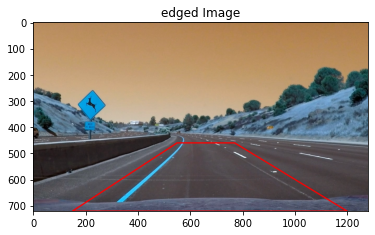

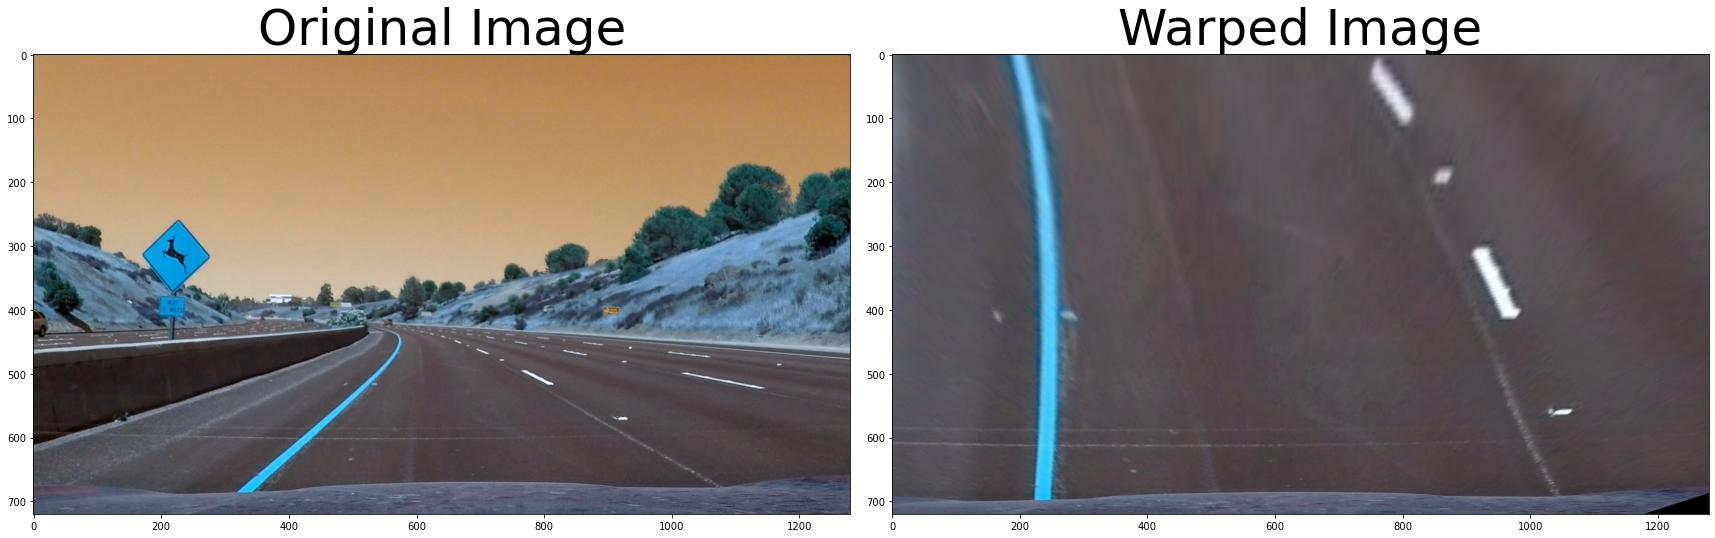

In [63]:
test_image = cv2.imread('./test_images/test2.jpg')
#warped, M_inv,edged_one = binary(test_image)
warped = forward_perspective(test_image)
edged_one = detected_original(test_image)
plt.imshow(edged_one, cmap='gray')
plt.title('edged Image')

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)

#left_fit, right_fit, out_img, lefty, leftx, righty, rightx, ploty = fitlines(warped)
#left_curverad, right_curverad = lane_curvatures(lefty, leftx, righty, rightx, ploty)
#radius = lane_curvatures(lefty, leftx, righty, rightx, ploty)
#marked_lane = draw_lane(warped, ploty)

#marked_lane = draw_lane(test_imgage, warped, left_fit, right_fit, ploty, left_curverad, right_curverad, M_inv)

#plt.figure(figsize=(20,10))
#plt.imshow(marked_lane);

# Vedio

In [ ]:
#import numpy as np
#import cv2
#from google.colab.patches import cv2_imshow #if not using colab delete this line
cap = cv2.VideoCapture('project_video.mp4') #enter the url of the video
while(cap.isOpened()):
  ret, frame = cap.read() #the frame is like the image
  #print(ret)
  if ret == True:
    #warped, M_inv,edged_one = binary(frame)
    # Display the resulting frame19
    #cv2.imshow('Frame',edged_one)
  ###################code edge detection ################################
  #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 

########################end of code##############################
  #cv2_imshow(gray) # if not using collab make the function : cv2.imshaow("title",gray)
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()
